In [1]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [2]:
import logging
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
!ls -lha ../input

total 8.0K
drwxr-xr-x 4 root   root    4.0K Mar 22 18:57 .
drwxr-xr-x 5 root   root    4.0K Mar 22 18:57 ..
drwxr-xr-x 5 nobody nogroup    0 Mar  5 18:37 planet-understanding-the-amazon-from-space
drwxr-xr-x 4 nobody nogroup    0 Mar 13 17:02 planets-dataset


In [4]:
PLANET_KAGGLE_ROOT = os.path.abspath("../input/planets-dataset/planet/planet/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_classes.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [5]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [7]:
label_onehot = labels_df.copy()

for label in label_list:
    label_onehot[label] = label_onehot['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
label_onehot.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

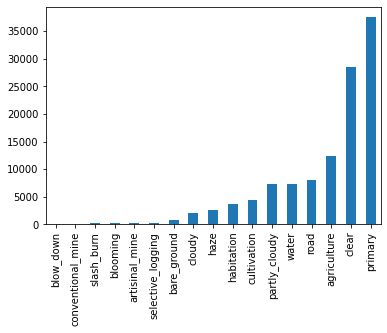

In [8]:
# Histogram of label instances
label_onehot[label_list].sum().sort_values().plot.bar()

In [9]:
# Converting labels to lists to be used in the classification
labels_df['tags'] = labels_df['tags'].str.split(" ")
# Display head
labels_df.head()

,image_name,tags
0,train_0,"[haze, primary]"
1,train_1,"[agriculture, clear, primary, water]"
2,train_2,"[clear, primary]"
3,train_3,"[clear, primary]"
4,train_4,"[agriculture, clear, habitation, primary, road]"


In [10]:
# Pull a list of 20000 image names
jpg_list = os.listdir(PLANET_KAGGLE_JPEG_DIR)[:20000]
# Select a random sample of 100 among those
np.random.shuffle(jpg_list)
jpg_list = jpg_list[:100]

print(jpg_list)

['train_2853.jpg', 'train_4065.jpg', 'train_15557.jpg', 'train_14793.jpg', 'train_22102.jpg', 'train_18311.jpg', 'train_15439.jpg', 'train_37850.jpg', 'train_26136.jpg', 'train_20212.jpg', 'train_37203.jpg', 'train_18097.jpg', 'train_10821.jpg', 'train_30772.jpg', 'train_4627.jpg', 'train_21377.jpg', 'train_12443.jpg', 'train_26299.jpg', 'train_36152.jpg', 'train_26157.jpg', 'train_38906.jpg', 'train_37626.jpg', 'train_35829.jpg', 'train_27962.jpg', 'train_3292.jpg', 'train_39155.jpg', 'train_14555.jpg', 'train_17402.jpg', 'train_2061.jpg', 'train_16442.jpg', 'train_18995.jpg', 'train_36403.jpg', 'train_862.jpg', 'train_16880.jpg', 'train_24207.jpg', 'train_25825.jpg', 'train_34045.jpg', 'train_18166.jpg', 'train_12892.jpg', 'train_18089.jpg', 'train_35863.jpg', 'train_13595.jpg', 'train_15015.jpg', 'train_40073.jpg', 'train_35904.jpg', 'train_39946.jpg', 'train_586.jpg', 'train_8180.jpg', 'train_18851.jpg', 'train_11029.jpg', 'train_39250.jpg', 'train_23343.jpg', 'train_31759.jpg', 't

In [11]:
labels_df.head()

,image_name,tags
0,train_0,"[haze, primary]"
1,train_1,"[agriculture, clear, primary, water]"
2,train_2,"[clear, primary]"
3,train_3,"[clear, primary]"
4,train_4,"[agriculture, clear, habitation, primary, road]"


In [12]:
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

from utils import *

### Cleaning Dataset

In [13]:
labels_df.isna().any()

image_name    False
tags          False
dtype: bool

### Splitting data to Train and Validation data

In [14]:
labels_df.columns

Index(['image_name', 'tags'], dtype='object')

In [15]:
X_train, X_val, y_train, y_val = train_test_split(labels_df['image_name'], 
    labels_df['tags'], 
    test_size=0.2, 
    random_state=20)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  32383
Number of posters for validation:  8096


In [16]:
X_train = [os.path.join(PLANET_KAGGLE_JPEG_DIR, str(f)+'.jpg') for f in X_train]
X_val = [os.path.join(PLANET_KAGGLE_JPEG_DIR, str(f)+'.jpg') for f in X_val]
X_train[:3]

['/kaggle/input/planets-dataset/planet/planet/train-jpg/train_17887.jpg',
 '/kaggle/input/planets-dataset/planet/planet/train-jpg/train_3697.jpg',
 '/kaggle/input/planets-dataset/planet/planet/train-jpg/train_16275.jpg']

In [17]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['partly_cloudy', 'primary'],
 ['agriculture', 'clear', 'cultivation', 'habitation', 'primary', 'road'],
 ['clear', 'primary']]

### Visualizing the images with their labels

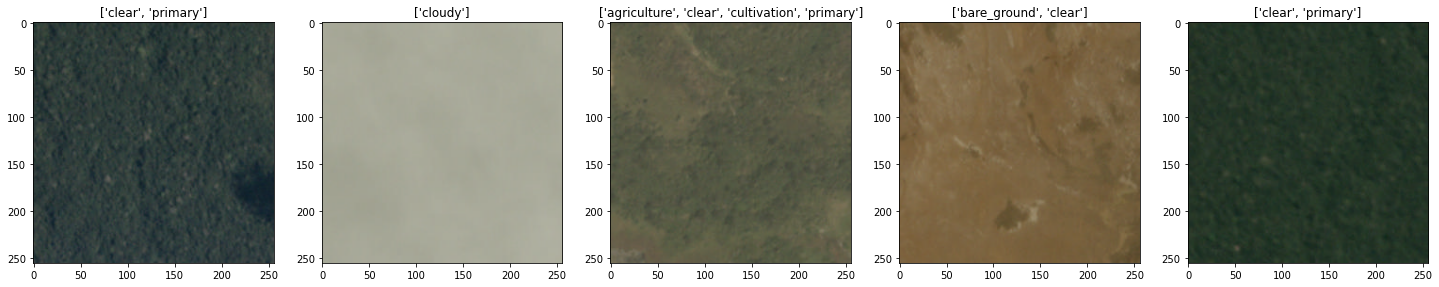

In [18]:
fig = plt.figure()
fig.set_size_inches(25, 5)

for i in range(5):
    file_path = os.path.join(PLANET_KAGGLE_JPEG_DIR, jpg_list[i])
    title = labels_df[labels_df['image_name'] == jpg_list[i][:-4]].tags.values[0]
    image = Image.open(file_path)
    
    a = fig.add_subplot(1, 5, i+1)
    
    plt.imshow(image)
    a.set_title(title)
    

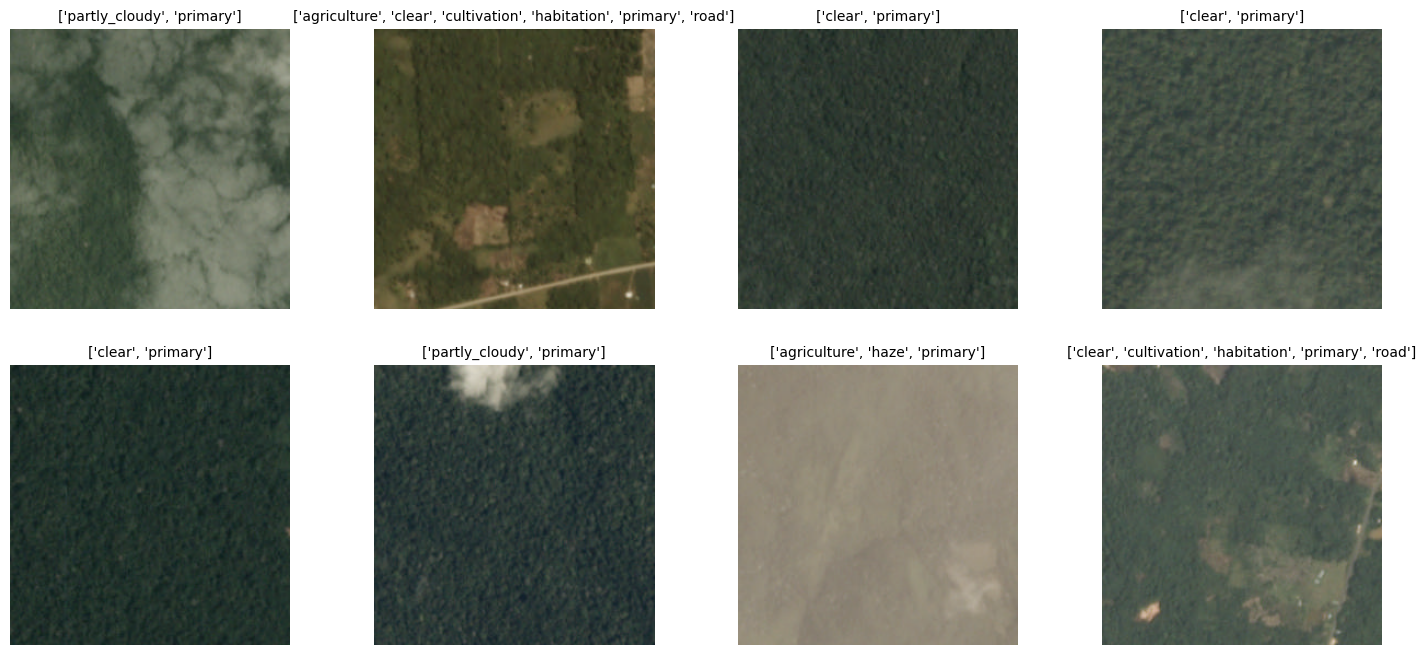

In [19]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(18,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

### Preprocessing

In [20]:
print("Labels:")
mlb = MultiLabelBinarizer()

mlb.fit(y_train)

N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. agriculture
1. artisinal_mine
2. bare_ground
3. blooming
4. blow_down
5. clear
6. cloudy
7. conventional_mine
8. cultivation
9. habitation
10. haze
11. partly_cloudy
12. primary
13. road
14. selective_logging
15. slash_burn
16. water


In [21]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

In [22]:
# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])

/kaggle/input/planets-dataset/planet/planet/train-jpg/train_17887.jpg [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
/kaggle/input/planets-dataset/planet/planet/train-jpg/train_3697.jpg [1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0]
/kaggle/input/planets-dataset/planet/planet/train-jpg/train_16275.jpg [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]


### Dataset Creation

In [23]:
IMG_SIZE = 224
CHANNELS = 3

In [24]:
def parse_function(filename, label):
    
   # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [25]:
BATCH_SIZE = 100

SHUFFLE_BUFFER_SIZE = 512

AUTOTUNE = tf.data.AUTOTUNE

In [26]:
def create_dataset(filenames, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    
    if is_training == True:
        dataset = dataset.cache()
        
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [27]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

2022-03-22 19:06:12.930265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 19:06:13.009171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 19:06:13.009930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 19:06:13.012190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [28]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

2022-03-22 19:06:15.299649: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Shape of features array: (100, 224, 224, 3)
Shape of labels array: (100, 17)


2022-03-22 19:06:17.678513: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [29]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    

(100, 224, 224, 3)
(100, 17)


2022-03-22 19:06:23.533287: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Model Building

In [30]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [31]:
feature_extractor_layer.trainable = False

In [32]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(100, activation='relu', name='hidden_layer'),
    layers.Dropout(0.3),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 100)               128100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
output (Dense)               (None, 17)                1717      
Total params: 2,397,901
Trainable params: 139,917
Non-trainable params: 2,257,984
________________________________________

In [33]:
for batch in train_ds:
    print(model.predict(batch)[:1])
    break

2022-03-22 19:07:03.877589: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


[[0.51773787 0.3840635  0.49962348 0.63320535 0.41010156 0.4720177
  0.6443722  0.54461706 0.3266841  0.7626579  0.18753497 0.57823795
  0.3976271  0.4414989  0.64752454 0.58017343 0.67652065]]


2022-03-22 19:07:13.390564: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Model Training

In [34]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [35]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [36]:
LR = 0.01
EPOCHS = 20

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=macro_soft_f1,
    metrics=[macro_f1]
)

In [ ]:
start = datetime.now()
history = model.fit(train_ds,
                   epochs=EPOCHS,
                   validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(datetime.now()-start)))

Epoch 1/20
178/324 [===============>..............] - ETA: 56s - loss: 0.7756 - macro_f1: 0.2242